## 3D Layered Surrogate PINN (Training Version)

In [18]:
import os
import gc
import time
import random
import numpy as np
import sciann as sn
import matplotlib.pyplot as plt

from sciann.utils.math import sign, abs, sigmoid, tanh, diff

In [2]:
s, minute, hr, day, year = 1., 60., 60.**2, 24*60.**2, 24*60.**2*365.25
mm, cm, m, km = 1e-3, 1e-2, 1.0, 1e3
Pa, kPa, MPa, GPa = 1.0, 1.e3, 1.e6, 1.e9

# ----------------------- Constant Parameters-------------------------
p0 = 1.0*Pa
p_star = 1.0*Pa

x_min, x_max = 0., 1.0
y_min, y_max = 0., 1.0
z_min, z_max = 0., 1.0
t_min, t_max = 0., 1.0

In [3]:
# ----------------------- Neural Network Setup -----------------------
sn.reset_session()
sn.set_random_seed(12345)

xd = sn.Variable('xd', dtype='float32')
yd = sn.Variable('yd', dtype='float32')
zd = sn.Variable('zd', dtype='float32')
td = sn.Variable('td', dtype='float32')

cv1 = sn.Variable('cv1', dtype='float32')
cv2 = sn.Variable('cv2', dtype='float32')
cv3 = sn.Variable('cv3', dtype='float32')

pd = sn.Functional('pd', [xd, yd, zd, td, cv1, cv2, cv3], 4*[40], 'tanh') # change layers?

In [4]:
# Exact solution data
# Define the directory to save the pore pressure data
save_directory = './pressure_data/'
os.makedirs(save_directory, exist_ok=True)

N = 60

xs = np.linspace(0, 1, N)
ys = np.linspace(0, 1, N)
zs = np.linspace(0, 1, N)
ts = np.linspace(0, 1, 21600)

file_path = './training_data/input_data_27.npz'
loaded_data = np.load(file_path)

# Access the data arrays
x_star = loaded_data['x_star']
y_star = loaded_data['y_star']
z_star = loaded_data['z_star']
t_star = loaded_data['t_star']
cv1_star = loaded_data['cv1_star']
cv2_star = loaded_data['cv2_star']
cv3_star = loaded_data['cv3_star']
pdata_star = loaded_data['pdata_star']

print("Loading process complete.")

input_data_3D = [x_star, y_star, z_star, t_star, cv1_star, cv2_star, cv3_star]
targets_vals = [pdata_star] + 10*['zeros'] # 10 zeros

Loading process complete.


In [5]:
def get_cv(cv1, cv2, cv3, zd):
    return (cv3 * (2/3 <= zd) * (zd <= 1.0)) + (cv2 * (1/3 <= zd) * (zd < 2/3)) + (cv1 * (0 <= zd) * (zd < 1/3))

In [6]:
# ----------- 3D Terzaghi Layered Problem (Physics) -----------------
pd_x, pd_y, pd_z, pd_t = diff(pd, xd), diff(pd, yd), diff(pd, zd), diff(pd, td)
pd_xx = diff(pd_x, xd)
pd_yy = diff(pd_y, yd)
pd_zz = diff(pd_z, zd)

pd_xy = diff(pd_x, yd)
pd_xyz = diff(pd_xy, zd)

# PDE Equation and BCs
PDE_3D = get_cv(cv1,cv2,cv3,zd)*(pd_xx + pd_yy + pd_zz) - pd_t

bc_ini = (td == t_min) * abs(pd - p0/p_star)
bc_left = (xd == x_min) * abs(pd)
bc_right = (xd == x_max) * abs(pd)
bc_front = (yd == y_min) * abs(pd)
bc_back = (yd == y_max) * abs(pd)
bc_bottom = (zd == z_min) * abs(pd_z)
bc_top = (zd == z_max) * abs(pd_z)

# Continuity of pore pressure and flux at layer interfaces
eps = 1/N

layer3 = (zd == (2/3 + eps)) *  abs(pd) * cv3 
layer2_top = (zd == (2/3 - eps)) * abs(pd) * cv2
layer2_bot = (zd == (1/3 + eps)) * abs(pd) * cv2
layer1 = (zd == (1/3 - eps)) * abs(pd) * cv1

p23 = (zd == 2/3) * abs(pd)
p12 = (zd == 1/3) * abs(pd)

interface_2_3 = (layer2_top + layer3) - p23*(cv3+cv2)
interface_1_2 = (layer2_bot + layer1) - p12*(cv2+cv1)

targets_3D = [sn.Data(pd), sn.PDE(PDE_3D), bc_ini, bc_left, bc_right, bc_front, bc_back, bc_bottom, bc_top, interface_1_2, interface_2_3]

In [9]:
# ------ Hyperparameters ---------
epochs = 10 # testing (> 5k required for visibly accurate sol.)
batch_size = 500

initial_lr = 1e-3
final_lr = initial_lr/100

learning_rate = {
"scheduler": "ExponentialDecay", 
"initial_learning_rate": initial_lr,
"final_learning_rate": final_lr, 
"decay_epochs": epochs
}

In [10]:
model = sn.SciModel(
    [xd, yd, zd, td, cv1, cv2, cv3],
    targets_3D,
    "mse",
    "Adam"
)

H = model.train(
    input_data_3D,
    targets_vals,
    epochs=epochs,
    batch_size=batch_size,
    stop_loss_value=1e-8,
    learning_rate=([0, epochs], [1e-3, 1e-3]),  # Fixed learning rate # 5e-4 or 1e-3
    #learning_rate=learning_rate,
    reduce_lr_after=None,  # Disable ReduceLROnPlateau
    reduce_lr_min_delta=None,
    shuffle=False,
    stop_after=None,
    verbose=2
)

model.save_weights(f'./weights/Terzaghi_3D_Layered_Final_{epochs}.hdf5')


Total samples: 135000 
Batch size: 500 
Total batches: 270 

Epoch 1/10
270/270 - 4s - loss: 0.0403 - pd_loss: 0.0229 - sub_loss: 0.0120 - mul_7_loss: 1.2614e-05 - mul_8_loss: 0.0011 - mul_9_loss: 0.0012 - mul_10_loss: 0.0011 - mul_11_loss: 0.0012 - mul_12_loss: 3.8010e-04 - mul_13_loss: 3.8386e-04 - sub_3_loss: 0.0000e+00 - sub_2_loss: 0.0000e+00 - lr: 0.0010 - time: 3.5553 - 4s/epoch - 13ms/step
Epoch 2/10
270/270 - 2s - loss: 0.0390 - pd_loss: 0.0220 - sub_loss: 0.0117 - mul_7_loss: 1.1828e-05 - mul_8_loss: 0.0011 - mul_9_loss: 0.0012 - mul_10_loss: 0.0011 - mul_11_loss: 0.0011 - mul_12_loss: 3.4376e-04 - mul_13_loss: 3.7067e-04 - sub_3_loss: 0.0000e+00 - sub_2_loss: 0.0000e+00 - lr: 0.0010 - time: 1.6662 - 2s/epoch - 6ms/step
Epoch 3/10
270/270 - 2s - loss: 0.0379 - pd_loss: 0.0214 - sub_loss: 0.0115 - mul_7_loss: 1.2524e-05 - mul_8_loss: 0.0010 - mul_9_loss: 0.0012 - mul_10_loss: 0.0011 - mul_11_loss: 0.0011 - mul_12_loss: 3.5699e-04 - mul_13_loss: 3.2065e-04 - sub_3_loss: 0.0000

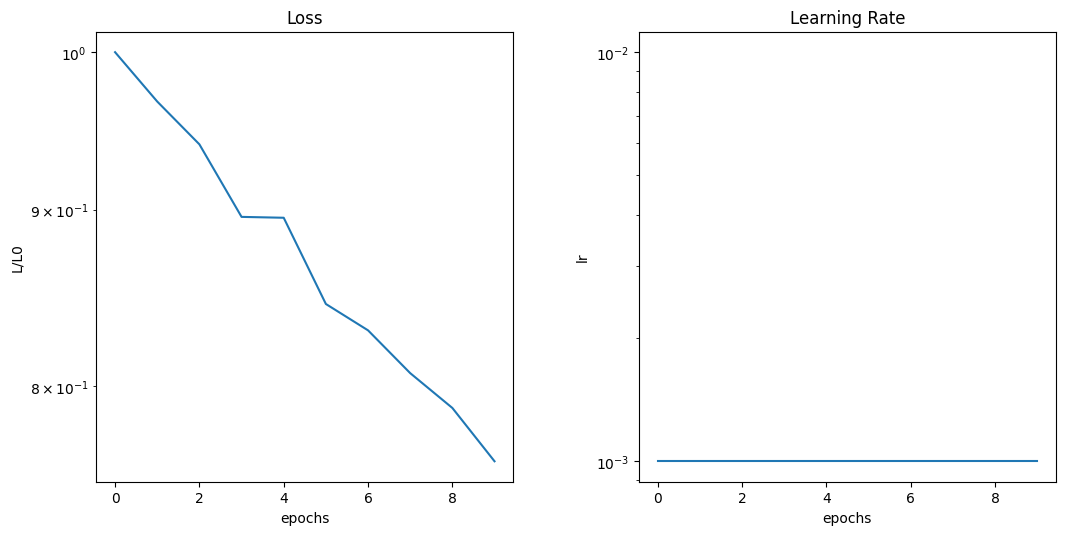

In [11]:
loss = H.history["loss"]
learning_rate = H.history["lr"]

def cust_semilogx(AX, X, Y, xlabel, ylabel, title):
    if X is None:
        im = AX.semilogy(Y)
    else:
        im = AX.semilogy(X, Y)
    if xlabel is not None: AX.set_xlabel(xlabel)
    if ylabel is not None: AX.set_ylabel(ylabel)
    if title is not None: AX.set_title(title)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

cust_semilogx(ax[0], None, np.array(loss) / loss[0], "epochs", "L/L0", "Loss")
cust_semilogx(ax[1], None, np.array(learning_rate), "epochs", "lr", "Learning Rate")

fig.subplots_adjust(left=0.1, right=0.9, bottom=0.15, top=0.9, wspace=0.3, hspace=0.2)

### Forward Solution

In [19]:
### -------- Plotting Arrays ---------
N = 60

# Define the evaluation grid
xs = np.linspace(0, 1, N)
ys = np.linspace(0, 1, N)
zs = np.linspace(0, 1, N)
ts = np.linspace(0, 1, 21600)

Xtest, Ytest, Ztest = np.meshgrid(xs, ys, zs, indexing='ij')
x_flat = Xtest.flatten()
y_flat = Ytest.flatten()
z_flat = Ztest.flatten()

mask = (y_flat >= 0.5) & (y_flat <= 1.0)

t_index = int(0.5 * (21600-1)) # using t = 0.5 to plot.

# Define the valid cv choices (unique layers)
valid_choices = list(permutations((0.015, 0.04, 0.065, 0.09), 3))

C:\Users\Umar\AppData\Local\Temp\ipykernel_4184\3589550692.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


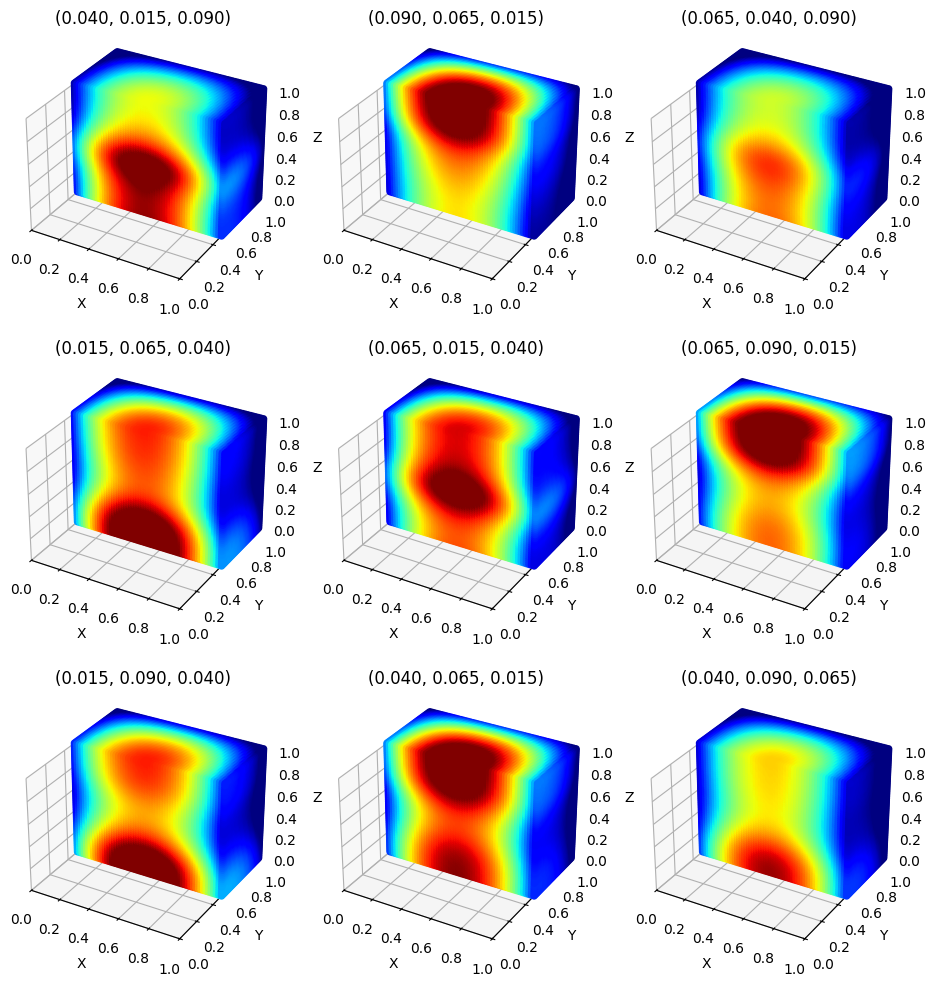

In [20]:
# Randomly select 9 unique (cv1, cv2, cv3) sets
selected_choices = random.sample(valid_choices, 9)

# Create a 3x3 grid figure
fig, axes = plt.subplots(3, 3, figsize=(12, 12), subplot_kw={'projection': '3d'}, gridspec_kw={'hspace': 0.25, 'wspace': 0.025})

for idx, (cv1, cv2, cv3) in enumerate(selected_choices):
    ax = axes[idx // 3, idx % 3]  # Access the correct subplot

    # Define cv arrays
    cv1_arr = np.full_like(x_flat, cv1)
    cv2_arr = np.full_like(x_flat, cv2)
    cv3_arr = np.full_like(x_flat, cv3)

    # Define test input
    input_test = [x_flat, y_flat, z_flat, np.full_like(x_flat, 0.5), cv1_arr, cv2_arr, cv3_arr]

    # Model evaluation (ensure `p_pred_fixed_time` is reshaped and masked correctly)
    p_pred_fixed_time = pd.eval(input_test).reshape(Xtest.shape).flatten()

    # Apply mask for y values between 0.5 and 1
    x_masked, y_masked, z_masked, p_masked = x_flat[mask], y_flat[mask], z_flat[mask], p_pred_fixed_time[mask]

    # Scatter plot with mask applied
    scatter = ax.scatter(x_masked, y_masked, z_masked, c=p_masked, cmap='jet', marker='o', alpha=1.0, vmin=0, vmax=1)

    # Set axis limits and labels
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_zlim([0, 1])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'({cv1:.3f}, {cv2:.3f}, {cv3:.3f})')

# Adjust layout for better spacing
plt.tight_layout()

Generating these plots, although very inaccurate, is very impressive after only 10 epochs (or 30 seconds) of training!

**Comparison plots are shown in the subsequent final notebook using the weights for 50k epochs trained with a L40S GPU. This requires lots of data and memory usage.**